# This notebook is intended to generate color images by stacking multi-band images

### Import packages

In [1]:
import glob
import sep
import numpy as np
from astropy.wcs import WCS
import astropy.io.fits as pyfits
from matplotlib import pyplot as plt
from scipy.ndimage import interpolation as interp
from scipy.ndimage import gaussian_filter

# Outline:

At the beginning of the class we tried to observe some Messier objects with a robotic telescope. Now we're going to put those data together to make a color image, or what astronomers often call an RGB image. Astronomical imaging is usually performed in specific filters which only allow certain wavelengths of light to pass through them. If you observe an object in 3 different filters, then each image you get will be a greyscale image, but you can assign each image a primary color (red/green/blue) and combine them to make a color image. Which is what we're going to do today.

# What filters did we observe with?

First we need to figure out what filters we observed with and which to assign to which primary color.

We can quickly find this out by opening each fits file (FITS is the image format typically used in astronomy) and extracting the filter information from the file header.

In this example we're going to be using images of M83 that were taken in 2021 (hopefully you have already downloaded these).

In [2]:
files = glob.glob('M83*fits')
filters = []
for file in files:
    #get the filter from the header
    _filter = pyfits.getheader(file)['FILTER']
    filters.append(_filter)
filters = np.array(filters)
files = np.array(files)
print ('All the filters we have: ', np.unique(filters))

All the filters we have:  ['B' 'R' 'V']


## Question:

<font color=blue>
Which filter should we assign to Red, Green, and Blue?
</font>

# Assign each image to a filter name

It is possible, and is often planned, that there are multiple images (or exposures) in a single filter. We don't want to throw away any good data, so we can average together exposures in the same filter, which will reduce the amount of random noise in the image.

The first step in doing this is to collect together all the images and assign each a filter name. This kind of assignment is a good match for a python dictionary. In this case with only a small number of images you could write this dictionary manually, but if you had 100 or 1000 images that becomes much more inefficient. So we're going to using python to do this for us.

## Exercise!

<font color=blue>
    Create a Dictionary called: <b>info</b><br>
    Where:
    <ul>
        <li>keys = filter names (strings)</li>
        <li>values = a list [] of file names for the images observed with that filter</li>
    </ul>
</font>

#### Hints
 * a dictionary is instantiated as: `info = {'B':[], 'R':[], 'V':[]}`
 * create a loop over the files (like above) and `info[filter].append()` those files to their correct filter dictionary element 

In [3]:
info = {'B':[], 'R':[], 'V':[]}

for file in files:
    _filter = pyfits.getheader(file)['FILTER']
    print(_filter)
    info[_filter].append(file)

print(info)

B
B
R
V
{'B': ['M83_AP_6150365_B_000.fits', 'M83_AP_6150365_B_001.fits'], 'R': ['M83_AP_6150365_R_002.fits'], 'V': ['M83_AP_6150365_V_001.fits']}


Great! We will use this dictionary to combine any images taken in the same filter in a moment, but first we need to get an idea of what the data are like.

# Visualize the data from one filter

Now let's do what we normally do and visualize data ...

## Exercise
<font color=blue>
    <ul>
        <li>Grab the filename of the B band entry's first image from our dictionary.</li>
        <li>Plot a histogram of the pixel values from the entire image.</li>
    </ul>
</font>

#### Hints

* use the `pyfits.getdata(filename)` to get the image data
* plot it using `plt.hist(data.flatten(), bins=nbins, range=(lower, higher))`
    * you'll have to figure out nbins, lower, higher on your own ;)

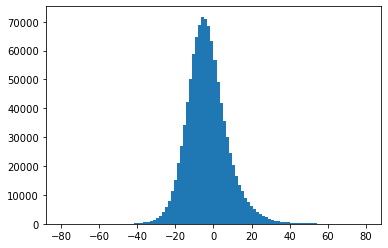

In [4]:
data = pyfits.getdata(info['B'][0])
image_hist = plt.hist(data.flatten(), bins=100, range=(-80, 80))

# Now...

Let's display this image as an example.

## Question:

<font color=blue>From the histogram above, what values would you use for `vmin` and `vmax`?</font>

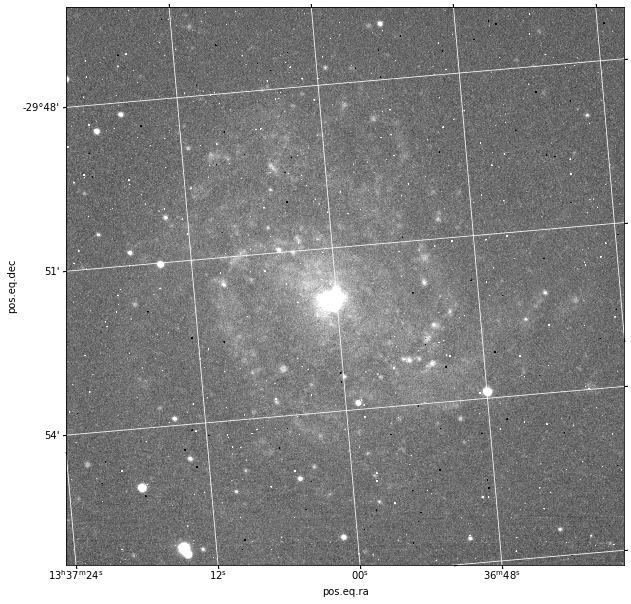

In [5]:
vmin, vmax =  -40, 40

fig= plt.figure(figsize=(10,12))

#grab the coordinate solution to plot the RA/DEC grid
header = pyfits.getheader(info['B'][0])
wcs = WCS(header)
ax = plt.subplot(projection=wcs)

#plot the image
data = pyfits.getdata(info['B'][0])
ax.imshow(data, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
ax.grid(color='white', ls='solid')

# Image Stacking

Now we're going to stack (combine) images that were taken in the same filter.

### How to:

* Loop over each filter
    * create a temporary dataset full of zeroes at the size we need
    * loop over each file in the respective filters file_list
        * get the image data and add it to our temporary dataset
    * average the coadded data by the number of files
    * save our averaged data to a dictionary with filters as the key
    
Note: Here we will use a normal average (e.g. mean), but often using the median is better for astronomical images as this removes outliers more effectively.

In [6]:
#Here is the dictionary we want to return
band_image = {}
#the size of our image: e.g. 1024x1024
image_size = np.shape(data)

#loop over our filter:files dictionary
for band in info.keys():
    print('Stacking all images in filter: {}'.format(band))
    #creating a temporary data array
    _data = np.zeros(image_size)
    
    #loop over our files list
    band_files = info[band]
    for file in band_files:
        #add up all of our data
        _data += pyfits.getdata(file)
    
    averaged_data = _data/float(len(band_files))
    band_image.update({band: averaged_data})

Stacking all images in filter: B
Stacking all images in filter: R
Stacking all images in filter: V


# Plot the stacked data

Now let's plot the combined image from the B band (in the M83 example).

We're going to use exactly the same plotting function as before, but now the input data are different.

## Question:


<font color=blue>We created the dictionary `band_image` which contains the combined images for each filter. How do we need to re-define `data` before passing it to the `imshow` function?</font>


In [7]:
data = band_image['B']

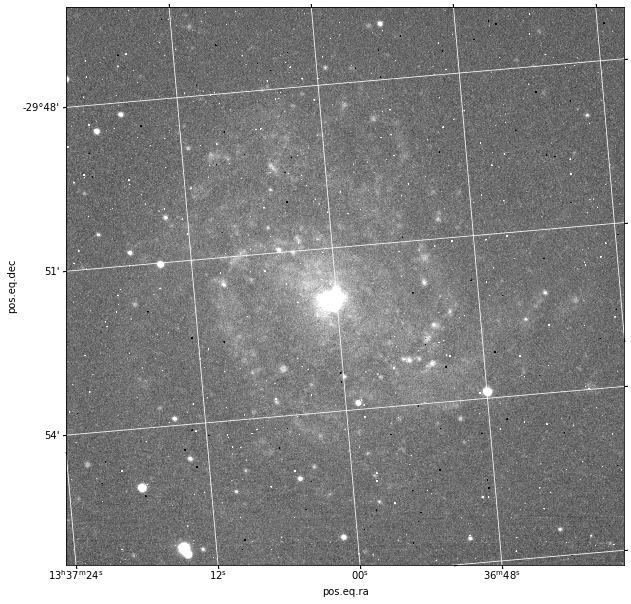

In [8]:
fig= plt.figure(figsize=(10,12))

#grab the coordinate solution to plot the RA/DEC grid
header = pyfits.getheader(info['B'][0])
wcs = WCS(header)
ax = plt.subplot(projection=wcs)

#plot the image
data = pyfits.getdata(info['B'][0])
ax.imshow(data, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
ax.grid(color='white', ls='solid')

# Make an RGB image

* How will we do this:
    * our bands need to be ordered from red-blue
    * we loop over these ordered bands
        * append the data to our `simpleRGB` list after applying a scale factor 
        * the scale factor will be from 0-1, closer to 1 the brighter the image will be in that color
        
    * `ax.imshow(simpleRGB)`

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


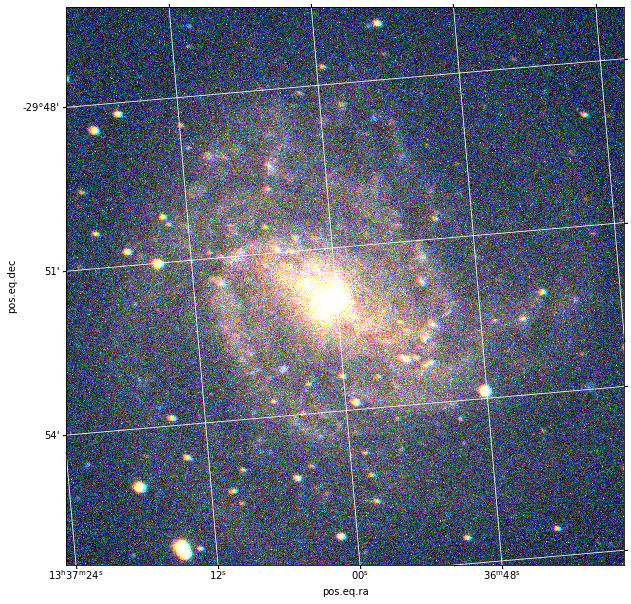

In [9]:
bands = ['R', 'V', 'B'] # This needs to be ordered as R/G/B

scale_factor = np.array([1.0, 0.9, 1.0]) 

simpleRGB=np.zeros((image_size[0],image_size[1],3),dtype=float)

for i in range(len(bands)):
    data = band_image[bands[i]].copy()
    min_value = np.percentile(data, 2) #2nd percentile to 98th percentile
    max_value = np.percentile(data, 98)
    
    #Scale the data so that the range goes from 0 to 1 for each image
    data = (data - min_value)/(max_value-min_value)
    
    #Place the data for the current filter in the appropriate part of simpleRGB
    simpleRGB[:,:,i]=(data*scale_factor[i])**1

fig= plt.figure(figsize=(10,12))
ax = plt.subplot(projection=wcs)
ax.grid(color='white', ls='solid')
img = ax.imshow(simpleRGB, origin='lower', interpolation='nearest',vmin=-40, vmax=50)

# Hmmm....

It looks good, but not that great. The image stacking doesn't appear to be the greatest

## Question:

<font color=blue>
    <ul>
        <li>What signs can you see that there's a problem?</li>
        <li>What should be done about it?</li>
    </ul>
</font>

.

.

.

.

.

.

.

.


# Aligning the images

We need to align the images better to remove artifacts.

### How can we do this:

* set the first image in our list as a reference
* use `sep` to find the objects in the reference image
* before stacking and averaging our data. Loop over every object in the iterated image, and the reference objects
    * find the average offset by calculating the distance between the ref_obj and the iterated obj
    * use a `scipy.ndimage.interpolate.shift()` to shift our data based off the offset
* stack and average our offset image

In [10]:
#Here is a function that searches for a reference object
#once it finds it, it returns the shift in the x and y directions

def find_offset(ref_x, ref_y, _data):
    #Get the objects in our current image
    _data = _data.byteswap().newbyteorder()
    _data_bkg = sep.Background(_data)
    data_objs = sep.extract(_data, thresh=20.0, err=_data_bkg.globalrms, minarea=8)
    
    #loop over them and calculate their distances
    for i,j in enumerate(data_objs['x']):
        shift_x = ref_x - data_objs['x'][i]
        shift_y = ref_y - data_objs['y'][i]
        distance = np.sqrt((shift_x)**2+(shift_y)**2)
        
        # if the distance is less than this threshhold, its a match
        # return the offset x,y
        if distance < 10:
            return shift_x, shift_y
            break

In [11]:
shift_band_image = {}

simpleRGB=np.zeros((image_size[0],image_size[1],3),dtype=float)

image_size = np.shape(data)
#These commands get the reference image objects
ref_file = info[list(info.keys())[0]][0]
ref_img = pyfits.getdata(ref_file)
ref_img = ref_img.byteswap().newbyteorder() # magic command
ref_bkg = sep.Background(ref_img)
ref_objects = sep.extract(ref_img, thresh=20.0, err=ref_bkg.globalrms, minarea=10)

#loop over the bands: RGB
for band in info.keys():
    print('Stacking all images in filter: {}'.format(band))
    _shift_data = np.zeros(image_size)
    
    #loop over the files associated with each band
    for file in info[band]:
        
        #get the image data
        tmp_data = pyfits.getdata(file)
        
        #our lists to hold the offsets
        sx, sy = [], []
        
        #loop over each reference object
        for i,j in enumerate(ref_objects['x']):
            #find and append the offsets to our lists
            tmp_sx, tmp_sy = find_offset(ref_objects['x'][i], ref_objects['y'][i], tmp_data)
            sx.append(tmp_sx)
            sy.append(tmp_sy)

        #calculate the average offset
        shift_x, shift_y = np.mean(sx), np.mean(sy)

        print('Average offsets in x: {}, y: {}\n'.format(round(shift_x, 3), round(shift_y, 3)))
        
        #scipy method that shifts the image based off these offsets
        new_data = interp.shift(tmp_data, [shift_y, shift_x])
        #new coadded data from the shift
        _shift_data += new_data

    shift_band_image.update({band: _shift_data/float(len(info[band]))})

Stacking all images in filter: B
Average offsets in x: 0.0, y: 0.0

Average offsets in x: 0.0, y: 0.0

Stacking all images in filter: R
Average offsets in x: 6.918, y: -0.833

Stacking all images in filter: V
Average offsets in x: 2.734, y: -0.113



# Let's plot our aligned/stacked data 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


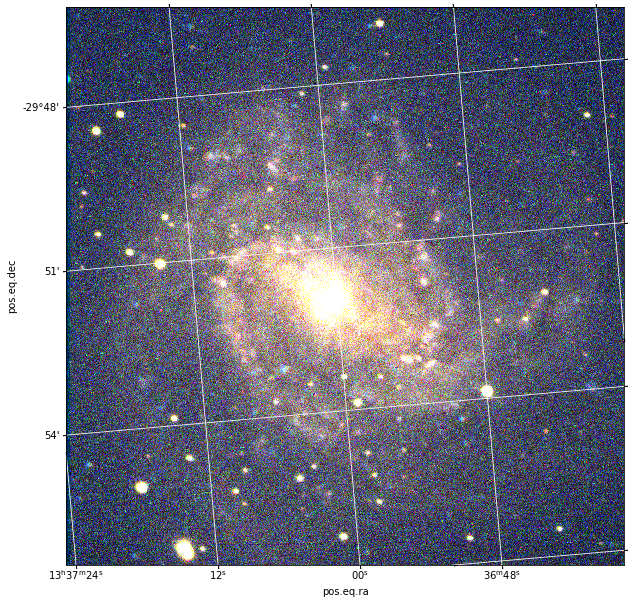

In [12]:
bands = ['R', 'V', 'B'] # This needs to be ordered as R/G/B

scale_factor = np.array([1.0, 0.9, 1.0]) 

simpleRGB=np.zeros((image_size[0],image_size[1],3),dtype=float)


for i in range(len(bands)):
    data = shift_band_image[bands[i]].copy()
    min_value = np.quantile(data, [0.03, 1-0.03])[0]
    max_value = np.quantile(data, [0.03, 1-0.03])[1]
    data = (data - min_value)/(max_value-min_value)
    simpleRGB[:,:,i]=(data*scale_factor[i])**1.

fig= plt.figure(figsize=(10,12))
ax = plt.subplot(projection=wcs)
ax.grid(color='white', ls='solid')
img = ax.imshow(simpleRGB, origin='lower', interpolation='nearest')

The mis-alignment is fixed! However, the image still looks pretty noisy and it's hard to clearly see the fainter regions of the galaxy. You can change the power the image is scaled by (`simpleRGB[:,:,i]=(data*scale_factor[i])**1.`), e.g. try 0.5 or 2, but this will only help so much. Setting the correct visual scale in astronomy is always a trade off. Making the fainter parts of the image stand out will result in the brightest parts being saturated. What scale you want to choose usually depends on what features you are most interested in e.g. the galactic nucleus of the edges of the spiral arms.

# Smooth the image

One simple way to enhance the image, reduce its noise, and bring out the faint features is to smooth (or blur) it. When smoothed random noise in adjacent pixels will tend to cancel out on average, but real emission coming from the galaxy won't cancel out. So the real emission will appear stronger against the background. The trade off is that the image will be more blurry. For some science cases it's vital to have high resolution images and smoothing is not really an option, but for investigations of diffuse, faint objects smoothing will likely be benefitial.

To perform the smoothing we will use the `scipy` function `gaussian_filter`. You cell phone camera probably has a Gaussian filter function. The function smooths/blurs the image using a Guassian function (a bell shape) of width N pixels. Here we're going to use N=2, but you can experiment with different values.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


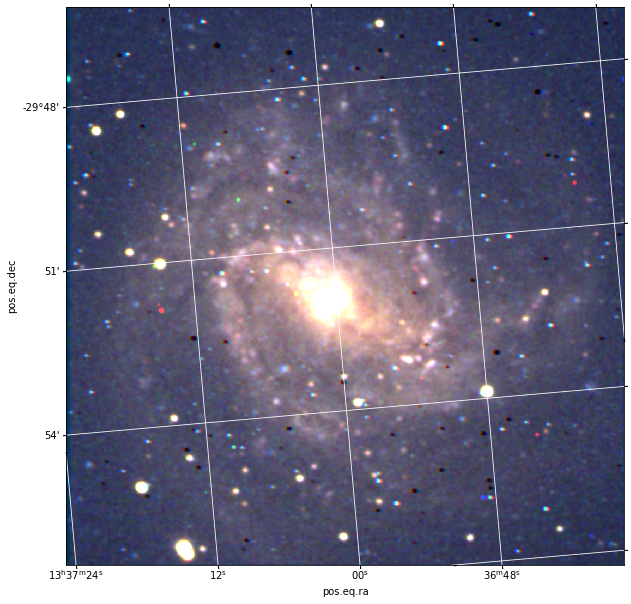

In [13]:
bands = ['R', 'V', 'B'] # This needs to be ordered as R/G/B
scale_factor = np.array([1.0, 0.85, 1.0])
size = 1024
simpleRGB=np.zeros((size,size,3),dtype=float)

N_smooth = 2


for i in range(len(bands)):
    data = shift_band_image[bands[i]].copy()
    min_value = np.percentile(data, 2) #2nd percentile to 98th percentile
    max_value = np.percentile(data, 98)
    data = (data - min_value)/(max_value-min_value)
    simpleRGB[:,:,i]=(data*scale_factor[i])**1.
    
    simpleRGB[:,:,i] = gaussian_filter(simpleRGB[:,:,i],N_smooth,mode='wrap')

fig= plt.figure(figsize=(10,12))
ax = plt.subplot(projection=wcs)
ax.grid(color='white', ls='solid')
img = ax.imshow(simpleRGB, origin='lower', interpolation='nearest')  

Ok, things are looking pretty good now. The image is aligned well, the smoothing reduced the noise and brought out the fainter features. However, there are black spots all over the image.

## Question:

<font color=blue>
    <ul>
        <li>What might be causing the black spots? </li>
        <li>Why are they visible in this image, but not the previous one? </li>
    </ul>
</font>

.

.

.

.

.

.


# Clip the image

To remove the black spots we can clip the image (before smoothing) to eliminate the bad pixels. In general in science you need to be very careful about modifying your data and this might create a bias in your final results. However, in this case our goal is to make a beautiful final image, like a publisher would for a popular science article, so this approach is ok. For an image which we were going to do science with, we would need to be more careful and identify each bad pixel and mask it.

To perform the clipping we will just take the `min_value` and `max_value` that we already defined and clip the data at these values using the `numpy` function `clip`, then smooth as before.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


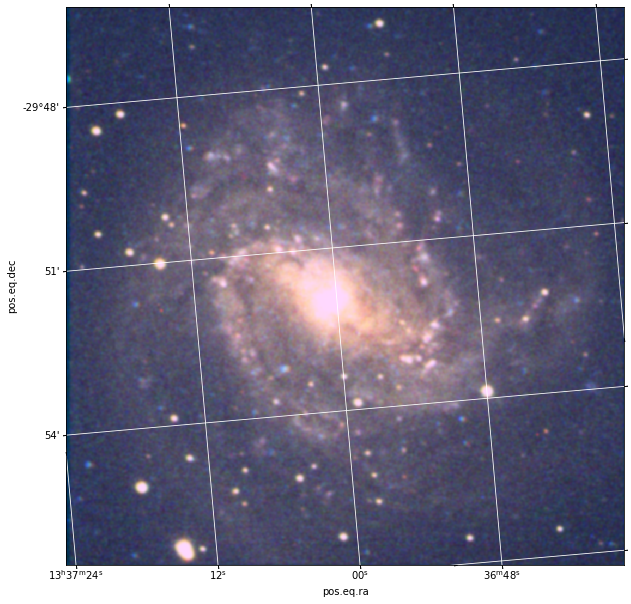

In [14]:
bands = ['R', 'V', 'B'] # This needs to be ordered as R/G/B
scale_factor = np.array([1.0, 0.85, 1.0])
size = 1024
simpleRGB=np.zeros((size,size,3),dtype=float)


for i in range(len(bands)):
    data = shift_band_image[bands[i]].copy()
    min_value = np.percentile(data, 2) #2nd percentile to 98th percentile
    max_value = np.percentile(data, 98)
    
    #data = (data - min_value)/(max_value-min_value)
    data = (np.clip(data,min_value,max_value) - min_value)/(max_value-min_value) #New line with clipping
    
    simpleRGB[:,:,i]=(data*scale_factor[i])**1.

    simpleRGB[:,:,i] = gaussian_filter(simpleRGB[:,:,i],2.,mode='wrap')

fig= plt.figure(figsize=(10,12))
ax = plt.subplot(projection=wcs)
ax.grid(color='white', ls='solid')
img = ax.imshow(simpleRGB, origin='lower', interpolation='nearest')  

# Perfect!

Show your friends and family, let them know you know how to make the Astronomy pictures the same way the Hubble does!

Save all of your notebooks and save them for future projects. Maybe you can try out creating a similar image for other objects observed with skynet.

It's been a wonderful semester, and I hope you have a great summer : )